In [27]:
import numpy as np  # Import numpy library for numerical computations
import pandas as pd  # Import pandas library for data manipulation and analysis
from pyDOE import lhs  # Import lhs function from pyDOE module for Latin Hypercube Sampling
import matplotlib.pyplot as plt # Import matplotlib to show image data

In [28]:
data = pd.read_csv('MNIST.csv')  # Read the data from the 'MNIST.csv' file into a pandas DataFrame
data = np.array(data)  # Convert the DataFrame to a numpy array
np.random.shuffle(data)  # Shuffle the rows of the data array randomly

In [29]:
m, n = data.shape  # Get the dimensions of the data array

# Extract the first 1000 rows for testing data and transpose them
data_test = data[0:1000].T
Y_test = data_test[0]  # Extract the labels for testing data
X_test = data_test[1:n]  # Extract the features for testing data
X_test = X_test / 255  # Normalise the features by dividing by 255 (maximum pixel value)

# Extract the remaining rows for training data and transpose them
data_train = data[1000:m].T
Y_train = data_train[0]  # Extract the labels for training data
X_train = data_train[1:n]  # Extract the features for training data
X_train = X_train / 255  # Normalise the features by dividing by 255 (maximum pixel value)

_, m_train = X_train.shape  # Get the number of training examples


In [30]:
data_train.shape  # Check the shape of the training data array

(785, 41000)

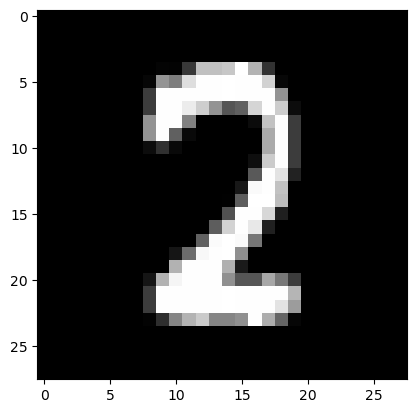

2


In [31]:
idx = np.random.randint(0, Y_train.size)
curr_img = X_train[:, idx, None]
curr_img = curr_img.reshape((28, 28)) * 255
plt.gray()
plt.imshow(curr_img)
plt.show()
print(Y_train[idx])

In [32]:
class Neural_Network:
    def __init__(self, input_size, hidden_1_size, hidden_2_size, output_size, learning_rate, data_num, bias = 1):
        """
        initialise the neural network with given parameters.

        Parameters:
        - input_size: Number of input features.
        - hidden_1_size: Number of neurons in the first hidden layer.
        - hidden_2_size: Number of neurons in the second hidden layer.
        - output_size: Number of output classes.
        - learning_rate: Learning rate for gradient descent.
        - data_num: Number of data points in the dataset.
        - bias: Bias term (default is 1).
        """
        self.input_size = input_size
        self.hidden_1_size = hidden_1_size
        self.hidden_2_size = hidden_2_size
        self.output_size = output_size
        self.learning_rate = learning_rate
        self.m = data_num

        # Xavier initialisation for weights
        self.W1 = np.random.randn(hidden_1_size, input_size) * np.sqrt(1.0 / input_size)
        self.b1 = np.zeros((hidden_1_size, bias))

        self.W2 = np.random.randn(hidden_2_size, hidden_1_size) * np.sqrt(1.0 / hidden_1_size)
        self.b2 = np.zeros((hidden_2_size, bias))

        self.W3 = np.random.randn(output_size, hidden_2_size) * np.sqrt(1.0 / hidden_2_size)
        self.b3 = np.zeros((output_size, bias))

    def set_learning_rate(self, new_LR):
        """
        Update the learning rate.

        Parameters:
        - new_LR: New learning rate value.
        """
        self.learning_rate = new_LR

    def forward_prop(self, X):
        """
        Perform forward propagation through the neural network.

        Parameters:
        - X: Input data matrix.
        """
        self.Z1 = self.W1.dot(X) + self.b1
        self.A1 = ReLU(self.Z1)

        self.Z2 = self.W2.dot(self.A1) + self.b2
        self.A2 = ReLU(self.Z2)

        self.Z3 = self.W3.dot(self.A2) + self.b3
        self.A3 = softmax(self.Z3)


    def backward_prop(self, X, y):
        """
        Perform backward propagation to compute gradients.

        Parameters:
        - X: Input data matrix.
        - y: True labels.
        """
        one_hot_Y = one_hot(y)

        self.dZ3 = self.A3 - one_hot_Y
        self.dW3 = 1 / self.m * self.dZ3.dot(self.A2.T)
        self.db3 = 1 / self.m * np.sum(self.dZ3, axis=1, keepdims=True)

        self.dZ2 = self.W3.T.dot(self.dZ3) * ReLU_prime(self.Z2)
        self.dW2 = 1 / self.m * self.dZ2.dot(self.A1.T)
        self.db2 = 1 / self.m * np.sum(self.dZ2, axis=1, keepdims=True)

        self.dZ1 = self.W2.T.dot(self.dZ2) * ReLU_prime(self.Z1)
        self.dW1 = 1 / self.m * self.dZ1.dot(X.T)
        self.db1 = 1 / self.m * np.sum(self.dZ1, axis=1, keepdims=True)

    def gradient_descent(self):
        """
        Update weights using gradient descent.
        """
        self.W1 = self.W1 - self.dW1 * self.learning_rate
        self.b1 = self.b1 - self.db1 * self.learning_rate

        self.W2 = self.W2 - self.dW2 * self.learning_rate
        self.b2 = self.b2 - self.db2 * self.learning_rate

        self.W3 = self.W3 - self.dW3 * self.learning_rate
        self.b3 = self.b3 - self.db3 * self.learning_rate

    def train_GD(self, epochs):
        """
        Train the neural network using batch gradient descent.

        Parameters:
        - epochs: Number of training epochs.
        """
        for epoch in range(epochs):
            self.forward_prop(X_train)
            self.backward_prop(X_train, Y_train)
            self.gradient_descent()

            if epoch % 10 == 0:
                self.forward_prop(X_train)
                predictions = np.argmax(self.A3, axis=0)        
                print(f'Epoch {epoch}: {round((np.sum(predictions == Y_train) / Y_train.size) * 100, 4)}%')

        self.forward_prop(X_test)
        predictions = np.argmax(self.A3, axis=0)
        print("Training complete\n")
        print(f'Test Set Accuracy: {round((np.sum(predictions == Y_test) / Y_test.size) * 100, 4)}%')



    def train_SGD(self, epochs, batch = 64):
        num_samples = X_train.shape[1]

        for epoch in range(epochs):
            indicies = np.random.permutation(num_samples)
            X_train_shuffled = X_train[:, indicies]
            Y_train_shuffled = Y_train[indicies]

            for i in range(0, num_samples, batch):
                X_batch = X_train_shuffled[:, i:i+batch]
                Y_batch = Y_train_shuffled[i:i+batch]

                self.forward_prop(X_batch)
                self.backward_prop(X_batch, Y_batch)
                self.gradient_descent()

            if epoch % 10 == 0:
                self.forward_prop(X_train)
                predictions = np.argmax(self.A3, axis=0)        
                print(f'Epoch {epoch}: {round((np.sum(predictions == Y_train) / Y_train.size) * 100, 4)}%')

        self.forward_prop(X_test)
        predictions = np.argmax(self.A3, axis=0)
        print("Training complete\n")
        print(f'Test Set Accuracy: {round((np.sum(predictions == Y_test) / Y_test.size) * 100, 4)}%')

    def train_adam(self, epochs):
        """
        Train the neural network using the Adam optimization algorithm.

        Parameters:
        - epochs: Number of training epochs.
        """        
        #Init Extra Weights
        self.beta1 = 0.6 # Exp decay rate for mean of gradients
        self.beta2 = 0.6 # Exp decay rate for varience of gradients
        self.epsilon = 1e-8 # Prevent divisions by 0
        
        self.m_W1 = np.zeros_like(self.W1) # Moving average of gradients
        self.v_W1 = np.zeros_like(self.W1) # Squared moving averages of gradients
        self.m_b1 = np.zeros_like(self.b1)
        self.v_b1 = np.zeros_like(self.b1)
        self.m_W2 = np.zeros_like(self.W2)
        self.v_W2 = np.zeros_like(self.W2)
        self.m_b2 = np.zeros_like(self.b2)
        self.v_b2 = np.zeros_like(self.b2)
        self.m_W3 = np.zeros_like(self.W3)
        self.v_W3 = np.zeros_like(self.W3)
        self.m_b3 = np.zeros_like(self.b3)
        self.v_b3 = np.zeros_like(self.b3)

        for epoch in range(epochs):
            # Perform forward and backward propagation
            self.forward_prop(X_train)
            self.backward_prop(X_train, Y_train)

            # Update parameters using Adam optimization rule
            self.adam_update()

            if epoch % 10 == 0:
                # Evaluate and print accuracy every 10 epochs
                self.forward_prop(X_train)
                predictions = np.argmax(self.A3, axis=0)
                print(f'Epoch {epoch}: {round((np.sum(predictions == Y_train) / Y_train.size) * 100, 4)}%')

        # Evaluate accuracy on test set after training
        self.forward_prop(X_test)
        predictions = np.argmax(self.A3, axis=0)
        print("Training complete\n")
        print(f'Test Set Accuracy: {round((np.sum(predictions == Y_test) / Y_test.size) * 100, 4)}%')


    def adam_update(self):
        """
        Update weights and biases using the Adam optimization algorithm.
        """

        # Update the first moment estimate of gradients for weights W1 using exponential decay
        self.m_W1 = self.beta1 * self.m_W1 + (1 - self.beta1) * self.dW1

        # Update the second moment estimate of gradients for weights W1 using exponential decay
        self.v_W1 = self.beta2 * self.v_W1 + (1 - self.beta2) * (self.dW1 ** 2)

        # Correct bias in the first moment estimate
        m_W1_hat = self.m_W1 / (1 - self.beta1)

        # Correct bias in the second moment estimate
        v_W1_hat = self.v_W1 / (1 - self.beta2)

        # Update weights W1 using the Adam optimisation update rule
        self.W1 -= self.learning_rate * m_W1_hat / (np.sqrt(v_W1_hat) + self.epsilon)

        #Repeat for following weights and biases

        self.m_b1 = self.beta1 * self.m_b1 + (1 - self.beta1) * self.db1
        self.v_b1 = self.beta2 * self.v_b1 + (1 - self.beta2) * (self.db1 ** 2)
        m_b1_hat = self.m_b1 / (1 - self.beta1)
        v_b1_hat = self.v_b1 / (1 - self.beta2)
        self.b1 -= self.learning_rate * m_b1_hat / (np.sqrt(v_b1_hat) + self.epsilon)

        self.m_W2 = self.beta1 * self.m_W2 + (1 - self.beta1) * self.dW2
        self.v_W2 = self.beta2 * self.v_W2 + (1 - self.beta2) * (self.dW2 ** 2)
        m_W2_hat = self.m_W2 / (1 - self.beta1)
        v_W2_hat = self.v_W2 / (1 - self.beta2)
        self.W2 -= self.learning_rate * m_W2_hat / (np.sqrt(v_W2_hat) + self.epsilon)

        self.m_b2 = self.beta1 * self.m_b2 + (1 - self.beta1) * self.db2
        self.v_b2 = self.beta2 * self.v_b2 + (1 - self.beta2) * (self.db2 ** 2)
        m_b2_hat = self.m_b2 / (1 - self.beta1)
        v_b2_hat = self.v_b2 / (1 - self.beta2)
        self.b2 -= self.learning_rate * m_b2_hat / (np.sqrt(v_b2_hat) + self.epsilon)

        self.m_W3 = self.beta1 * self.m_W3 + (1 - self.beta1) * self.dW3
        self.v_W3 = self.beta2 * self.v_W3 + (1 - self.beta2) * (self.dW3 ** 2)
        m_W3_hat = self.m_W3 / (1 - self.beta1)
        v_W3_hat = self.v_W3 / (1 - self.beta2)
        self.W3 -= self.learning_rate * m_W3_hat / (np.sqrt(v_W3_hat) + self.epsilon)

        self.m_b3 = self.beta1 * self.m_b3 + (1 - self.beta1) * self.db3
        self.v_b3 = self.beta2 * self.v_b3 + (1 - self.beta2) * (self.db3 ** 2)
        m_b3_hat = self.m_b3 / (1 - self.beta1)
        v_b3_hat = self.v_b3 / (1 - self.beta2)
        self.b3 -= self.learning_rate * m_b3_hat / (np.sqrt(v_b3_hat) + self.epsilon)

    
   
    def train_pso(self, epochs, n_particles=50, w_start=0.9, w_end=0.3, c1=0.5, c2=0.3):
        """
        Train the neural network using Particle Swarm Optimization (PSO).

        Parameters:
        - epochs: Number of training epochs.
        - n_particles: Number of particles (default is 50).
        - w_start: Initial inertia weight (default is 0.9).
        - w_end: Final inertia weight (default is 0.2).
        - c1: Cognitive parameter (default is 1.5).
        - c2: Social parameter (default is 1.5).
        """
        # initialise particles' positions using Latin Hypercube Sampling
        particle_positions = self._latin_hypercube_sampling(n_particles)
        # initialise particles' velocities
        particle_velocities = [np.random.randn(len(particle_positions[0])) * 0.1 for _ in range(n_particles)]
        # initialise personal best positions and scores
        personal_best_positions = particle_positions.copy()
        personal_best_scores = [self._evaluate_fitness(p) for p in personal_best_positions]
        # initialise global best position
        global_best_position = personal_best_positions[np.argmin(personal_best_scores)]

        for epoch in range(epochs):

            # Update inertia weight dynamically
            w = w_start - (w_start - w_end) * epoch / epochs

            for i in range(n_particles):
                # Update velocity
                r1, r2 = np.random.rand(), np.random.rand()
                particle_velocities[i] = (
                    w * particle_velocities[i]
                    + c1 * r1 * (personal_best_positions[i] - particle_positions[i])
                    + c2 * r2 * (global_best_position - particle_positions[i])
                )
                
                # Update position
                particle_positions[i] += particle_velocities[i]
                # Evaluate fitness
                score = self._evaluate_fitness(particle_positions[i])
                if score < self._evaluate_fitness(personal_best_positions[i]):
                    personal_best_positions[i] = particle_positions[i].copy()
                    if score < self._evaluate_fitness(global_best_position):
                        global_best_position = particle_positions[i].copy()

            if epoch % 1 == 0:
                # Set weights from the global best position and evaluate accuracy
                self._set_weights_from_vector(global_best_position)
                self.forward_prop(X_train)
                predictions = np.argmax(self.A3, axis=0)
                print(f'Epoch {epoch}: {round((np.sum(predictions == Y_train) / Y_train.size) * 100, 4)}%')

        # Set final weights from the global best position and evaluate accuracy on test set
        self._set_weights_from_vector(global_best_position)
        self.forward_prop(X_test)
        predictions = np.argmax(self.A3, axis=0)
        print("Training complete\n")
        print(f'Test Set Accuracy: {round((np.sum(predictions == Y_test) / Y_test.size) * 100, 4)}%')


    def _latin_hypercube_sampling(self, n_particles):
        """
        Generate Latin Hypercube Samples for particle positions.

        Parameters:
        - n_particles: Number of particles.

        Returns:
        - Scaled Latin Hypercube Samples for particle positions.
        """
        samples = lhs(self._get_weights_as_vector().size, samples=n_particles)
        min_val = -1.0
        max_val = 1.0
        scaled_samples = min_val + samples * (max_val - min_val)
        return scaled_samples

    def _get_weights_as_vector(self):
        """
        Concatenate weights and biases into a single vector.

        Returns:
        - Flattened vector containing weights and biases.
        """
        return np.concatenate([
            self.W1.flatten(), self.b1.flatten(),
            self.W2.flatten(), self.b2.flatten(),
            self.W3.flatten(), self.b3.flatten()
        ])

    def _set_weights_from_vector(self, vector):
        """
        Set weights and biases from a vector.

        Parameters:
        - vector: Vector containing weights and biases.
        """
        sizes = [
            self.W1.size, self.b1.size,
            self.W2.size, self.b2.size,
            self.W3.size, self.b3.size
        ]
        vectors = np.split(vector, np.cumsum(sizes)[:-1])
        self.W1 = vectors[0].reshape(self.W1.shape)
        self.b1 = vectors[1].reshape(self.b1.shape)
        self.W2 = vectors[2].reshape(self.W2.shape)
        self.b2 = vectors[3].reshape(self.b2.shape)
        self.W3 = vectors[4].reshape(self.W3.shape)
        self.b3 = vectors[5].reshape(self.b3.shape)

    def _evaluate_fitness(self, weights_vector):
        """
        Evaluate fitness using weights vector.

        Parameters:
        - weights_vector: Vector containing weights.

        Returns:
        - Negative accuracy for minimization.
        """
        self._set_weights_from_vector(weights_vector)
        self.forward_prop(X_train)
        predictions = np.argmax(self.A3, axis=0)
        return -np.sum(predictions == Y_train) / Y_train.size  # Negative accuracy for minimization





    def train(self, method, epochs):
        """
        Train the neural network using the specified method.

        Parameters:
        - method: String indicating the training method ('GD', 'SGD', 'adam', 'pso').
        - epochs: Number of training epochs.
        """
        if method == 'GD':
            self.train_GD(epochs)
        elif method == 'SGD':
            self.train_SGD(epochs)
        elif method == 'adam':
            self.train_adam(epochs)
        elif method == 'pso':
            self.train_pso(epochs)
        else:
            raise ValueError('Invalid Training Method')

def ReLU(Z):
    """
    ReLU activation function.

    Parameters:
    - Z: Input to the ReLU function.

    Returns:
    - Output of the ReLU function.
    """
    return np.maximum(Z, 0)

def ReLU_prime(Z):
    """
    Derivative of ReLU activation function.

    Parameters:
    - Z: Input to the ReLU function.

    Returns:
    - Derivative of the ReLU function.
    """
    return Z > 0

def sigmoid(Z):
    """
    Sigmoid activation function.

    Parameters:
    - Z: Input to the sigmoid function.

    Returns:
    - Output of the sigmoid function.
    """
    A = 1 / (1 + np.exp(np.clip(-Z, -4, 4)))
    return A

def sigmoid_prime(Z):
    """
    Derivative of sigmoid activation function.

    Parameters:
    - Z: Input to the sigmoid function.

    Returns:
    - Derivative of the sigmoid function.
    """
    A = sigmoid(Z) * (1 - sigmoid(Z))
    return A

def softmax(Z):
    """
    Softmax activation function.

    Parameters:
    - Z: Input to the softmax function.

    Returns:
    - Output of the softmax function.
    """
    Z_shifted = Z - np.max(Z, axis=0, keepdims=True)  # Shift values for numerical stability
    exp_Z = np.exp(Z_shifted)
    A = exp_Z / np.sum(exp_Z, axis=0, keepdims=True)
    return A

def one_hot(Y):
    """
    Convert class labels to one-hot encoding.

    Parameters:
    - Y: Class labels.

    Returns:
    - One-hot encoded representation of class labels.
    """
    one_hot_Y = np.zeros((Y.size, 10))
    one_hot_Y[np.arange(Y.size), Y] = 1
    one_hot_Y = one_hot_Y.T
    return one_hot_Y


In [33]:
nn = Neural_Network(784, 32, 16, 10, 0.01, m_train)

In [34]:
nn.set_learning_rate(0.05)
nn.train('adam', 200)

Epoch 0: 29.4244%
Epoch 10: 66.0854%
Epoch 20: 81.1098%
Epoch 30: 84.7024%
Epoch 40: 90.6537%
Epoch 50: 92.6293%
Epoch 60: 92.2537%
Epoch 70: 93.3561%
Epoch 80: 92.1439%
Epoch 90: 94.478%
Epoch 100: 95.1488%
Epoch 110: 95.6268%
Epoch 120: 95.2195%
Epoch 130: 96.5024%
Epoch 140: 94.7488%
Epoch 150: 95.0805%
Epoch 160: 93.3024%
Epoch 170: 96.3146%
Epoch 180: 96.1829%
Epoch 190: 96.5366%
Training complete

Test Set Accuracy: 94.2%
